In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime
import time
import unicodedata

from selenium import webdriver
from selenium.webdriver.chrome.options import Options  

In [2]:
chrome_options = Options()  
chrome_options.add_argument("--headless")  
chrome_options.add_argument("--no-sandbox")

driver = webdriver.Chrome('chromedriver', options=chrome_options)

In [3]:
datetime.now()

datetime.datetime(2020, 6, 5, 18, 8, 59, 840741)

In [4]:
url = 'https://www.health.gov.au/news/health-alerts/novel-coronavirus-2019-ncov-health-alert/coronavirus-covid-19-current-situation-and-case-numbers'


driver.get(url)



In [5]:
content = driver.page_source

In [6]:
date_time_str = re.search('(\d+ \w+ 202\d)' ,str(content)).group(1)
date_time_str

'05 June 2020'

In [7]:
data_date_time = datetime.strptime(date_time_str, '%d %B %Y').strftime('%Y-%m-%d')
data_date_time

'2020-06-05'

### Dataframe

In [8]:
for i in range(40): # retry and wait till the tables are loaded
    try:
        dfs = pd.read_html(driver.page_source)
        if len(dfs)>0:
            break
    except ValueError as e:
        print(e)
    time.sleep(1)
dfs

No tables found
No tables found
No tables found
No tables found
No tables found
No tables found
No tables found
No tables found


[  Jurisdiction Unnamed: 1  Total confirmed cases  New cases in last 24 hours  \
 0    Australia  Australia                   7251                          11   
 1          ACT        ACT                    107                           0   
 2          NSW        NSW                   3110                           4   
 3           NT         NT                     29                           0   
 4          QLD        QLD                   1060                           0   
 5           SA         SA                    440                           0   
 6          TAS        TAS                    228                           0   
 7          VIC        VIC                   1681                           3   
 8           WA         WA                    596                           4   
 
    Deaths  Unnamed: 5  
 0     102         NaN  
 1       3         NaN  
 2      48         NaN  
 3       0         NaN  
 4       6         NaN  
 5       4         NaN  
 6      13   

In [9]:
df = dfs[0]
df = df.iloc[:,1:3].T
df.columns = df.iloc[0]
df = df.drop(df.index[0])
df

Unnamed: 1,Australia,ACT,NSW,NT,QLD,SA,TAS,VIC,WA
Total confirmed cases,7251,107,3110,29,1060,440,228,1681,596


In [10]:


df.insert(0, 'date', data_date_time)
df = df.rename(columns={
    'Australia':'australia',
    'ACT':'act',
    'NSW':'nsw',
    'QLD':'qld',
    'SA':'sa',
    'TAS':'tas',
    'VIC':'victoria',
    'WA':'wa',
    'NT':'nt',
})
df

Unnamed: 1,date,australia,act,nsw,nt,qld,sa,tas,victoria,wa
Total confirmed cases,2020-06-05,7251,107,3110,29,1060,440,228,1681,596


In [11]:
assert int(df['australia'])>0

In [12]:
df

Unnamed: 1,date,australia,act,nsw,nt,qld,sa,tas,victoria,wa
Total confirmed cases,2020-06-05,7251,107,3110,29,1060,440,228,1681,596


### Save to file

In [13]:
from pathlib import Path
csv_file = '../data/australia-cases.csv'

if Path(csv_file).exists():
    # read out the old data
    old_df = pd.read_csv(csv_file)
    df = df.append(old_df)
df.drop_duplicates(subset=['date'], inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [14]:
df.sort_values(by=['date'], inplace=True)
df.to_csv(csv_file, index=False)
df

,act,australia,date,nsw,nt,qld,sa,tas,victoria,wa
0,NaN,12,2020-02-04,4,NaN,2,2,NaN,4,NaN
1,NaN,13,2020-02-05,4,NaN,3,2,NaN,4,NaN
2,NaN,14,2020-02-06,4,NaN,4,2,NaN,4,NaN
3,NaN,15,2020-02-07,4,NaN,5,2,NaN,4,NaN
4,NaN,15,2020-02-08,4,NaN,5,2,NaN,4,NaN
...,...,...,...,...,...,...,...,...,...,...
117,107,7204,2020-06-01,3098,29,1058,440,228,1653,591
118,107,7221,2020-06-02,3104,29,1059,440,228,1663,591
119,107,7229,2020-06-03,3104,29,1059,440,228,1670,592
120,107,7240,2020-06-04,3106,29,1060,440,228,1678,592


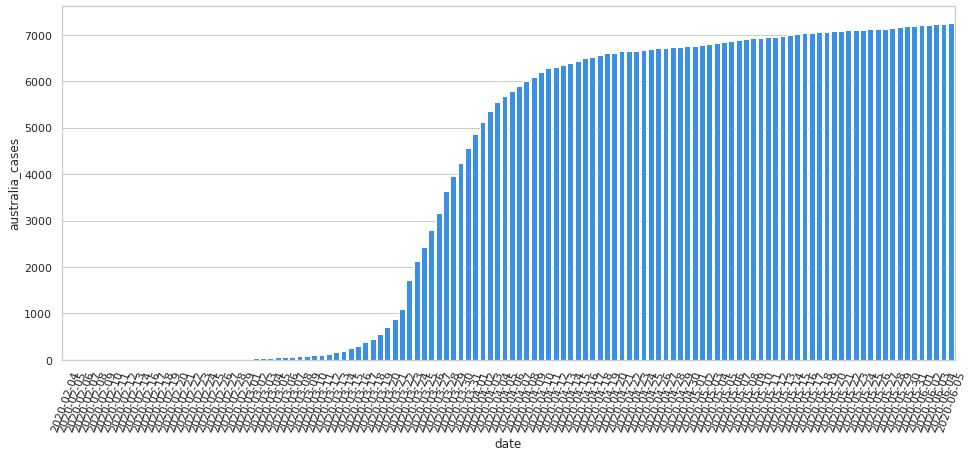

In [15]:
# plot
df['australia_cases']= df['australia'].apply(lambda x: int(x))

import seaborn as sns


sns.set(rc={'figure.figsize':(16,6.5)})
sns.set(style="whitegrid")


bar_chart = sns.barplot(x='date', y='australia_cases', color='dodgerblue', data=df)
bar_chart.tick_params(axis='x', labelrotation=70)


In [16]:
png_file = '../images/australia-cases.png'
bar_chart_fig = bar_chart.get_figure()
bar_chart_fig.savefig(png_file)
